In [1]:
import pyteomics.mzml
import spectrum_utils.spectrum as sus
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils.iplot as isup
import pandas as pd
import ppx

In [2]:
ppx.set_data_dir("data")
sc_data = ppx.find_project('MSV000087524')
sc_data.download("raw/Hela Single Cell QC mzML/Ex_Auto_J3_30umTB_2ngQC_60m_1.mzML", silent=True)

[WindowsPath('C:/Users/conno/Payne Lab/SCP_comp_review/data/MSV000087524/raw/Hela Single Cell QC mzML/Ex_Auto_J3_30umTB_2ngQC_60m_1.mzML')]

In [3]:
ppx.set_data_dir("data")
bulk_data = ppx.find_project('MSV000087689')
bulk_data.download("raw/Hela_bulk/OR11_20160122_PG_HeLa_CVB3_CT_A.mzML", silent=True)


[WindowsPath('C:/Users/conno/Payne Lab/SCP_comp_review/data/MSV000087689/raw/Hela_bulk/OR11_20160122_PG_HeLa_CVB3_CT_A.mzML')]

In [97]:
def get_spec(my_scan, my_peptide, mzml, collection, msRun):
    my_id = 'controllerType=0 controllerNumber=1 scan='+ my_scan
    spectrum_dict = mzml.get_by_id(my_id)
    
    usi = "mzspec:" + collection + ":" + msRun + ":scan:" + my_scan # + ":" + my_peptide
    
#    spectrum_id = spectrum_dict['id']
#    mz_array = spectrum_dict['m/z array']
#    intensity_array = spectrum_dict['intensity array']
#    retention_time1 = (spectrum_dict['scanList']['scan'][0].get('scan start time', -1))
    precursor = spectrum_dict['precursorList']['precursor'][0]
    precursor_ion = precursor['selectedIonList']['selectedIon'][0]
    precursor_mz1 = precursor_ion['selected ion m/z']

    if 'charge state' in precursor_ion:
        precursor_charge1 = int(precursor_ion['charge state'])
    elif 'possible charge state' in precursor_ion:
        precursor_charge1 = int(precursor_ion['possible charge state'])
    else:
        raise ValueError('Unknown precursor charge')
    
    scan_num = spectrum_dict["id"][spectrum_dict["id"].find('scan=') + 5:]
    ms_level = spectrum_dict["ms level"]
    total_ion_curr = spectrum_dict["total ion current"]
    ion_time = spectrum_dict["scanList"]['scan'][0]["ion injection time"]

    spectrum = sus.MsmsSpectrum.from_usi(usi, precursor_charge=precursor_charge1, precursor_mz=precursor_mz1)
 
    # Process the MS/MS spectrum.
    fragment_tol_mass = 50
    fragment_tol_mode = 'ppm'    
    spectrum = (spectrum.annotate_proforma(peptide, fragment_tol_mass, fragment_tol_mode,
                                            ion_types='by',max_ion_charge=2))
    
    return spectrum

In [69]:
mzml_2ng1 = pyteomics.mzml.MzML('data/MSV000087524/raw/Hela Single Cell QC mzML/Ex_Auto_J3_30umTB_2ngQC_60m_1.mzML')
mzml_bulk1 = pyteomics.mzml.MzML('data/MSV000087689/raw/Hela_bulk/OR11_20160122_PG_HeLa_CVB3_CT_A.mzML')

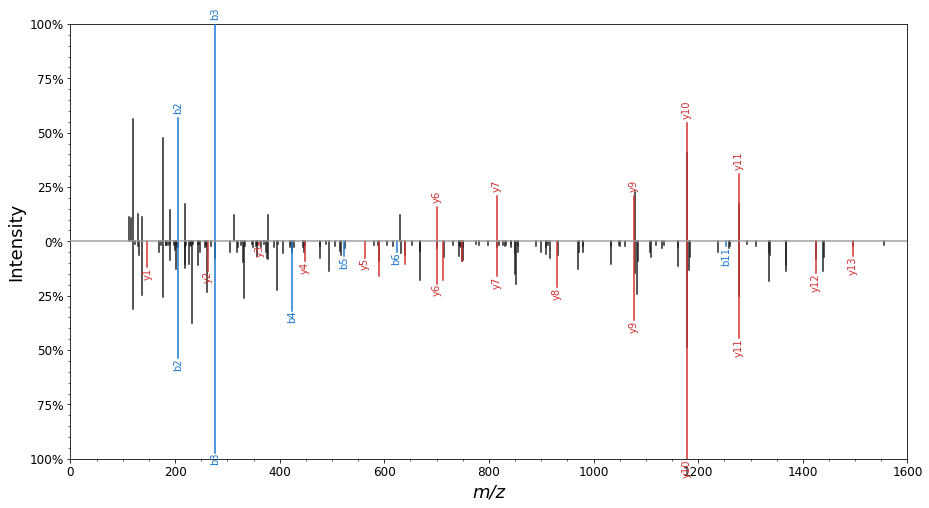

In [98]:
peptide ='GFAFVTFDDHDSVDK'
spectrum_bulk = get_spec('85781',peptide,mzml_bulk1, 'MSV000087689', "OR11_20160122_PG_HeLa_CVB3_CT_A")
spectrum_sc = get_spec('26417',peptide ,mzml_2ng1, 'MSV000087524', "Ex_Auto_J3_30umTB_2ngQC_60m_1")

fig, ax = plt.subplots(figsize=(15, 8))
sup.mirror(spectrum_sc,
           spectrum_bulk,
           ax=ax)
plt.xlim(0, 1600)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid(visible=False, which='both')
plt.xlabel('m/z', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.savefig('mirror_plot.png', dpi=600)
plt.show()